In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import Conv2D,Conv2DTranspose,BatchNormalization,LeakyReLU,Input,concatenate,Dropout,UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from keras.models import Model
import imgaug as ia
from imgaug import augmenters as iaa

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path_gray = '/content/drive/My Drive/dataset/gray/'
path_color = '/content/drive/My Drive/dataset/color/'

In [4]:
# sortiranje dobijenih podataka
def sort_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

In [5]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, color_path, gray_path, batch_size, image_size, image_names, pipeline = None, shuffle=True):
        'Initialization'
        self.color_path = color_path
        self.grayscale_path = gray_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.image_names = image_names
        self.shuffle = shuffle
        self.pipeline = pipeline
        self.indexes = np.arange(len(self.image_names))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_names) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_color_images = []
        batch_gray_images = []

        for i in indexes:
            rgb_image = cv2.imread(os.path.join(self.color_path, self.image_names[i]))
            rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
            rgb_image = cv2.resize(rgb_image, (self.image_size, self.image_size))
            rgb_image = rgb_image.astype("float32") / 255.0
            batch_color_images.append(img_to_array(rgb_image))

            grayscale_image = cv2.imread(os.path.join(self.grayscale_path, self.image_names[i]), cv2.IMREAD_GRAYSCALE)
            grayscale_image = cv2.resize(grayscale_image, (self.image_size, self.image_size))
            grayscale_image = grayscale_image.astype("float32") / 255.0
            grayscale_image = np.expand_dims(grayscale_image, axis=-1)
            batch_gray_images.append(grayscale_image)

        batch_color_images = np.array(batch_color_images)
        batch_gray_images = np.array(batch_gray_images)

        if self.pipeline is not None:
            batch_color_images, batch_gray_images = self.augment_images(batch_color_images, batch_gray_images)

        return batch_gray_images, batch_color_images

    def augment_images(self, color_images, gray_images):
        # Apply augmentations to color and grayscale images
        aug_color_images = self.pipeline(images=color_images)
        aug_gray_images = self.pipeline(images=gray_images)
        return aug_color_images, aug_gray_images

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_names))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [6]:
# Create the augmentation pipeline
pipeline = iaa.Sequential([
    iaa.Rot90((1, 3)),  # randomly rotate image from 90, 180, 270 degrees
])

In [7]:
# Podela podataka na trening i test skup podataka i pravljenje generatora podataka.
image_names = sort_alphanumeric(os.listdir(path_color))
TRAINING_SIZE = int(len(image_names) * 0.8)
train_image_names = image_names[:TRAINING_SIZE]
test_image_names = image_names[TRAINING_SIZE:]

In [8]:
len(image_names)


7129

In [9]:
train_generator = DataGenerator(path_color,path_gray,8,256,train_image_names,pipeline)
test_generator = DataGenerator(path_color,path_gray,8,256,test_image_names)

In [10]:
def up(filters, kernel_size, dropout=False):
    upsample = Sequential()
    upsample.add(Conv2DTranspose(filters, kernel_size, padding='same', strides=2))
    if dropout:
        upsample.add(Dropout(0.2))
    upsample.add(LeakyReLU())
    return upsample

In [11]:
def down(filters, kernel_size, apply_batch_normalization=True):
    downsample = Sequential()
    downsample.add(Conv2D(filters, kernel_size, padding='same', strides=2))
    if apply_batch_normalization:
        downsample.add(BatchNormalization())
    downsample.add(LeakyReLU())
    return downsample

In [12]:
def build_autoencoder():
    inputs = Input(shape= [256,256,1])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)

    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = concatenate([u5,inputs])
    output = Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [ ]:
# Build and compile the model
autoencoder = build_autoencoder()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['accuracy'])

# Check the model summary to see the tensor shapes
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 128)        1280      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 128)          147584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 256)          296192    ['sequential_1[0][0]']        
                                                                                              

In [ ]:
# Define the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)

# Train the model with the EarlyStopping and ModelCheckpoint callbacks
autoencoder.fit(train_generator, validation_data=test_generator, epochs=10, callbacks=[early_stopping, checkpoint])


Epoch 1/10
712/712 [==============================] - ETA: 0s - loss: 0.1972 - accuracy: 0.3350

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


712/712 [==============================] - 122s 156ms/step - loss: 0.1972 - accuracy: 0.3350 - val_loss: 0.0938 - val_accuracy: 0.3459
Epoch 2/10
712/712 [==============================] - 108s 152ms/step - loss: 0.1940 - accuracy: 0.3786 - val_loss: 0.1007 - val_accuracy: 0.4769
Epoch 3/10
712/712 [==============================] - 112s 157ms/step - loss: 0.1924 - accuracy: 0.3864 - val_loss: 0.0860 - val_accuracy: 0.4691
Epoch 4/10
712/712 [==============================] - 108s 152ms/step - loss: 0.1908 - accuracy: 0.3969 - val_loss: 0.0957 - val_accuracy: 0.4881
Epoch 5/10
712/712 [==============================] - 107s 150ms/step - loss: 0.1896 - accuracy: 0.4017 - val_loss: 0.0867 - val_accuracy: 0.4117
Epoch 6/10
712/712 [==============================] - 105s 147ms/step - loss: 0.1894 - accuracy: 0.4059 - val_loss: 0.0861 - val_accuracy: 0.4773
Epoch 7/10
712/712 [==============================] - 109s 153ms/step - loss: 0.1903 - accuracy: 0.4125 - val_loss: 0.0967 - val_accura

In [ ]:
autoencoder.evaluate(test_generator)

178/178 [==============================] - 19s 109ms/step - loss: 0.0860 - accuracy: 0.4694


[0.08598950505256653, 0.46944886445999146]

178/178 [==============================] - 19s 105ms/step - loss: 0.0860 - accuracy: 0.4692


[0.0860481709241867, 0.46921205520629883]

In [13]:
def generate_examples(model, test_generator, num_examples=5):
    count = 0
    for batch in test_generator:
        if count >= num_examples:
            break
        grayscale_images, rgb_images = batch
        predictions = model.predict(grayscale_images)
        for i in range(len(grayscale_images)):
            input_image = grayscale_images[i]
            target_image = rgb_images[i]
            predicted_image = predictions[i]
            display_list = [input_image, target_image, predicted_image]
            title = ["Input (Grayscale)", "Ground Truth (Color)", "Predicted (Color)"]
            plt.figure(figsize=(15, 5))
            for j in range(3):
                plt.subplot(1, 3, j + 1)
                plt.title(title[j])
                if j == 0:  # Grayscale image
                    plt.imshow(display_list[j], cmap='gray')
                else:
                    plt.imshow(display_list[j])
                plt.axis("off")
            plt.show()
            count += 1
            if count >= num_examples:
                break

1/1 [==============================] - 0s 350ms/step


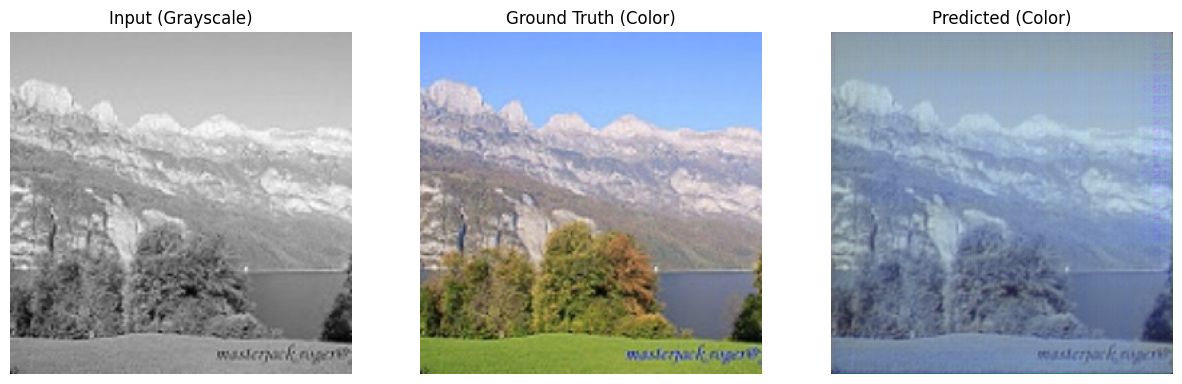

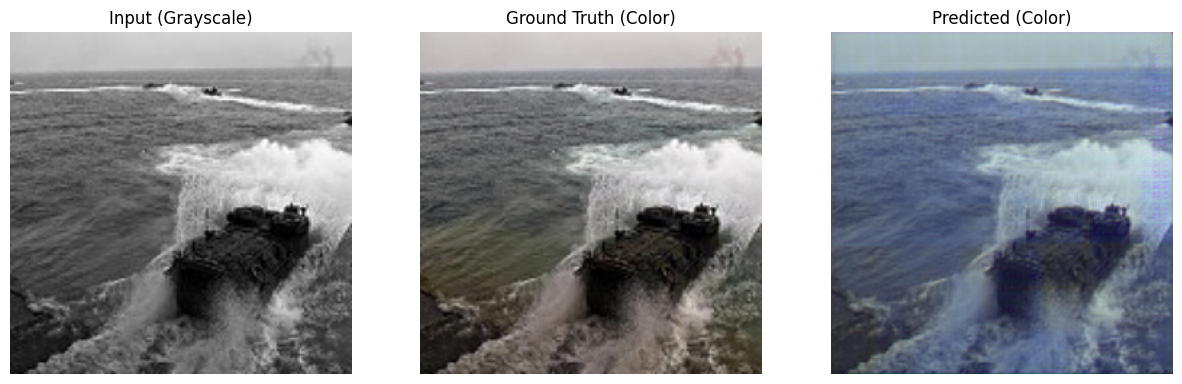

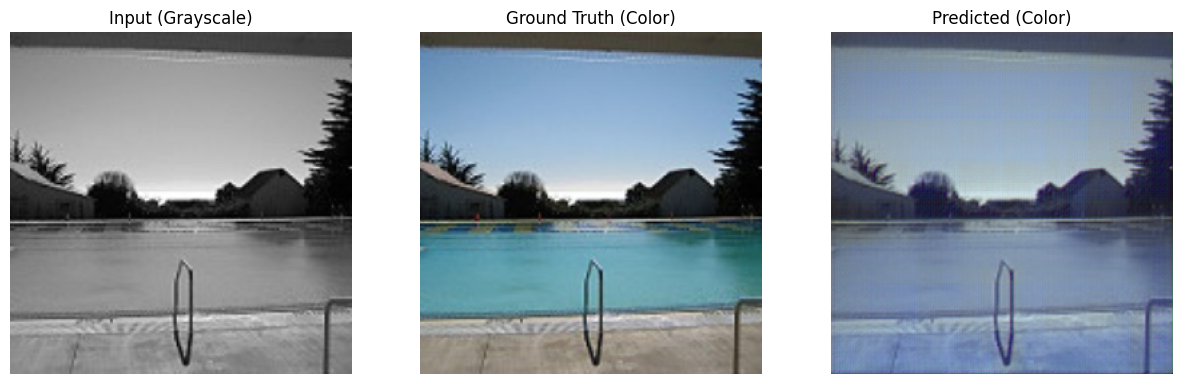

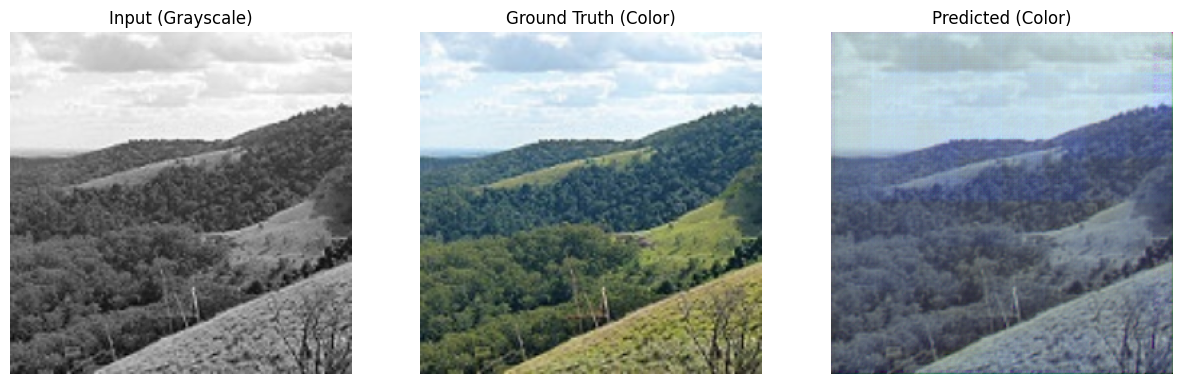

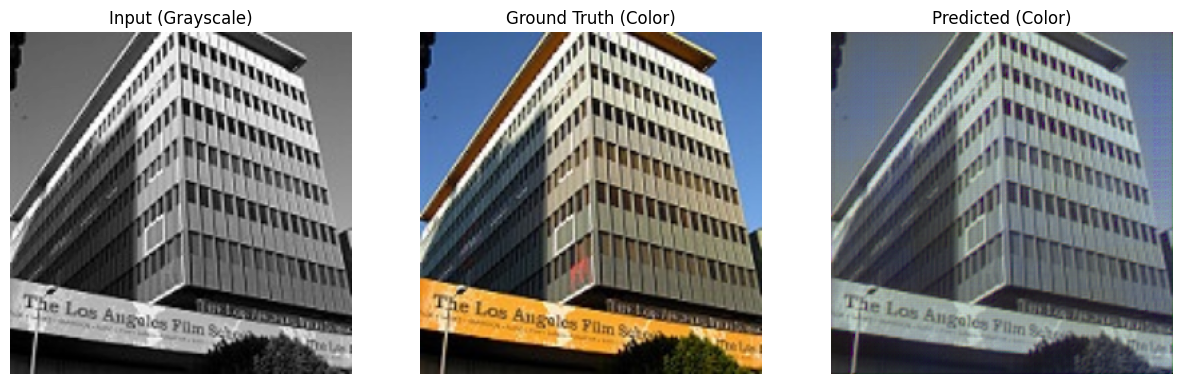

1/1 [==============================] - 0s 22ms/step


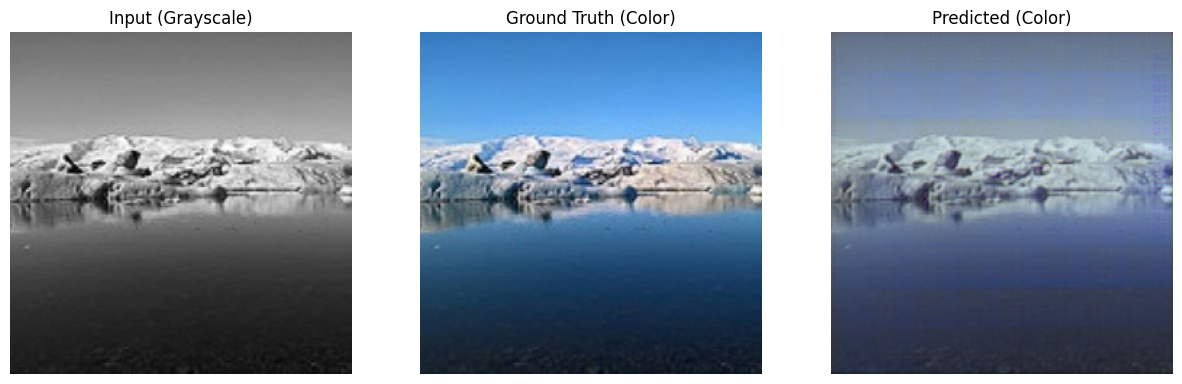

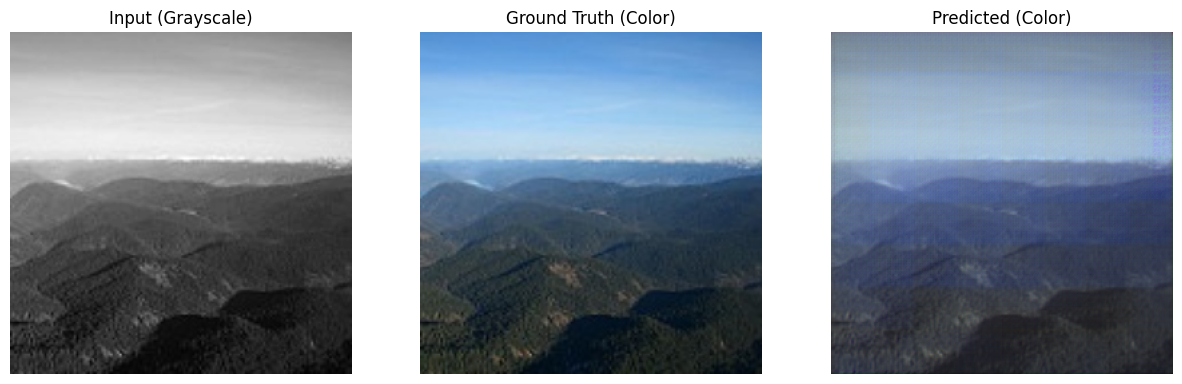

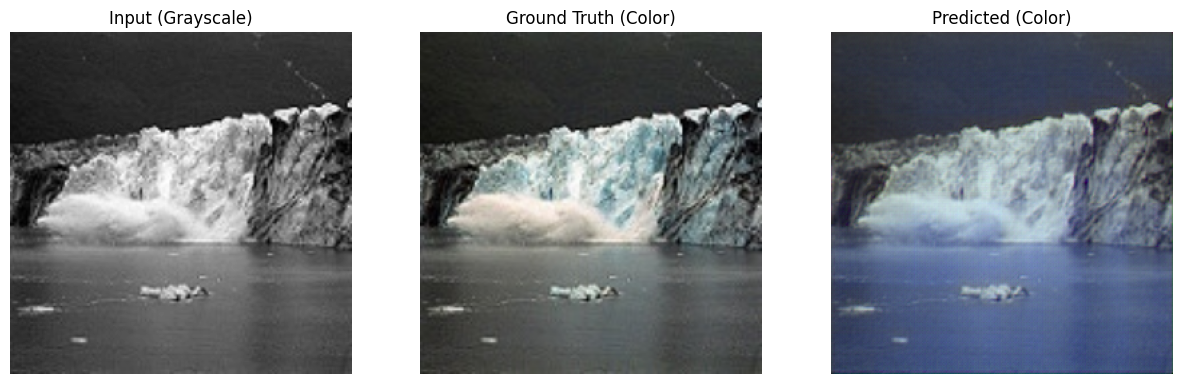

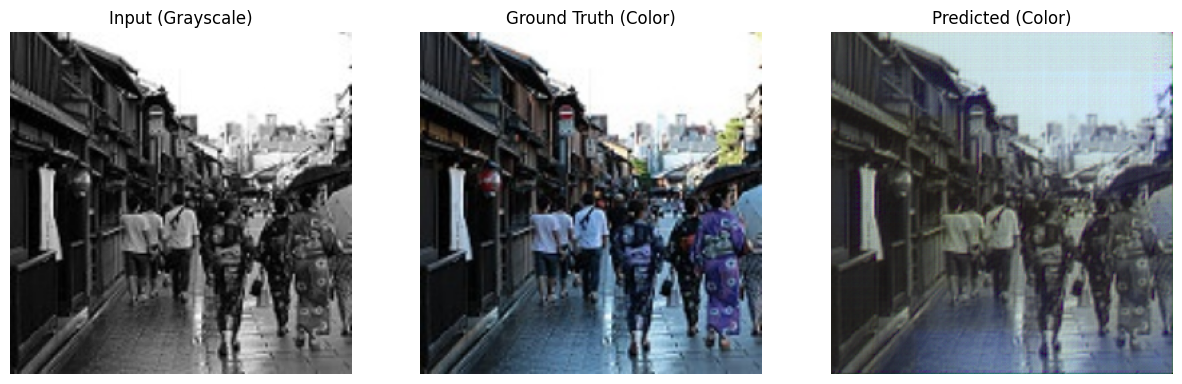

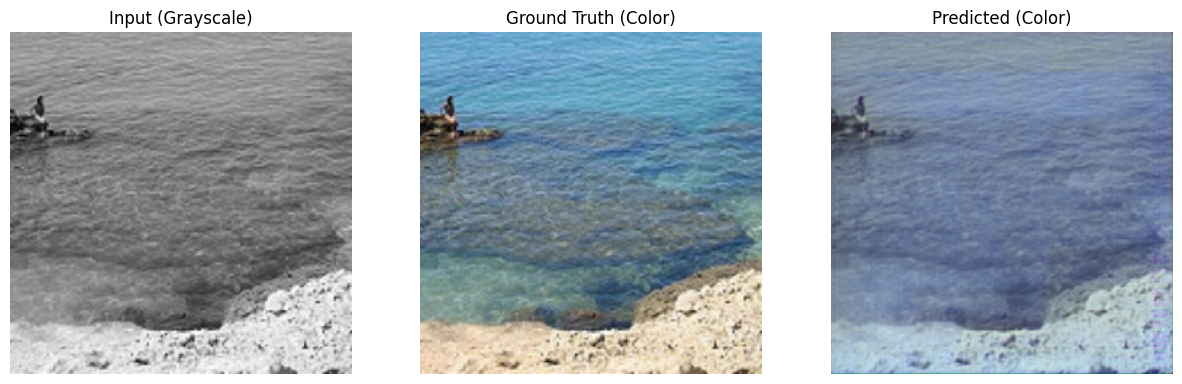

In [ ]:
generate_examples(autoencoder, test_generator, num_examples=5)

In [14]:
from tensorflow.keras import backend as K

def custom_l1_loss(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true - y_pred))

In [15]:
def test_and_evaluate(autoencoder,test_generator):
    total_l1_loss = 0
    for batch in tqdm(test_generator):
        grayscale_images, rgb_images = batch
        predictions = autoencoder.predict(grayscale_images)
        _, _, _, l1_loss = custom_l1_loss(rgb_images, predictions)
        total_l1_loss += l1_loss.numpy()

    return total_l1_loss

In [16]:
# Build and compile the model
autoencoder_l1 = build_autoencoder()
autoencoder_l1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss= custom_l1_loss, metrics=['accuracy'])

# Check the model summary to see the tensor shapes
autoencoder_l1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 128)        1280      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 128)          147584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 256)          296192    ['sequential_1[0][0]']        
                                                                                              

In [17]:
# Define the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)

# Train the model with the EarlyStopping and ModelCheckpoint callbacks
autoencoder_l1.fit(train_generator, validation_data=test_generator, epochs=10, callbacks=[early_stopping, checkpoint])

Epoch 1/10
712/712 [==============================] - ETA: 0s - loss: 313242.7188 - accuracy: 0.3146

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


712/712 [==============================] - 122s 157ms/step - loss: 313242.7188 - accuracy: 0.3146 - val_loss: 183639.0000 - val_accuracy: 0.2404
Epoch 2/10
712/712 [==============================] - 107s 150ms/step - loss: 302371.2188 - accuracy: 0.3630 - val_loss: 133689.7812 - val_accuracy: 0.3294
Epoch 3/10
712/712 [==============================] - 103s 145ms/step - loss: 300575.8750 - accuracy: 0.3710 - val_loss: 137730.1094 - val_accuracy: 0.3100
Epoch 4/10
712/712 [==============================] - 104s 147ms/step - loss: 300139.0000 - accuracy: 0.3805 - val_loss: 131348.3281 - val_accuracy: 0.4460
Epoch 5/10
712/712 [==============================] - 106s 148ms/step - loss: 297572.7500 - accuracy: 0.3815 - val_loss: 120720.3906 - val_accuracy: 0.4316
Epoch 6/10
712/712 [==============================] - 107s 151ms/step - loss: 295956.7500 - accuracy: 0.3869 - val_loss: 135468.0312 - val_accuracy: 0.4331
Epoch 7/10
712/712 [==============================] - 101s 142ms/step - los

In [18]:
autoencoder_l1.evaluate(test_generator)

178/178 [==============================] - 17s 97ms/step - loss: 120741.4141 - accuracy: 0.4316


[120741.4140625, 0.43158408999443054]

1/1 [==============================] - 0s 240ms/step


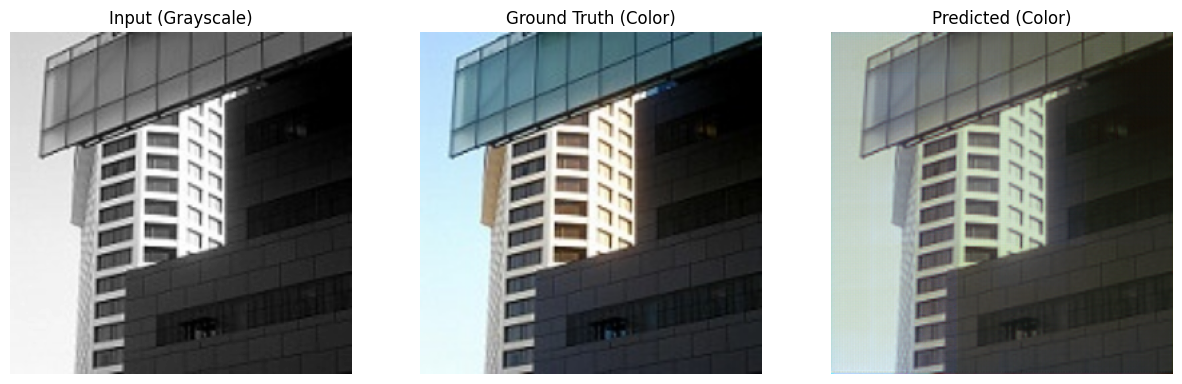

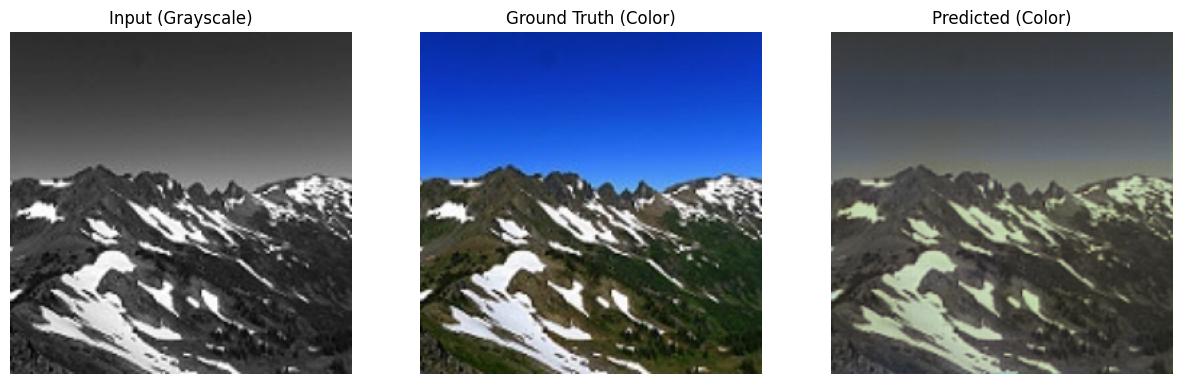

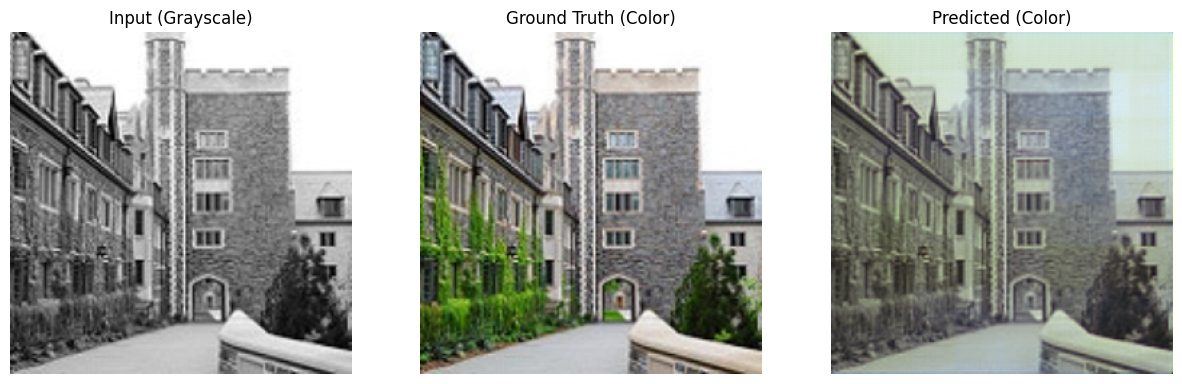

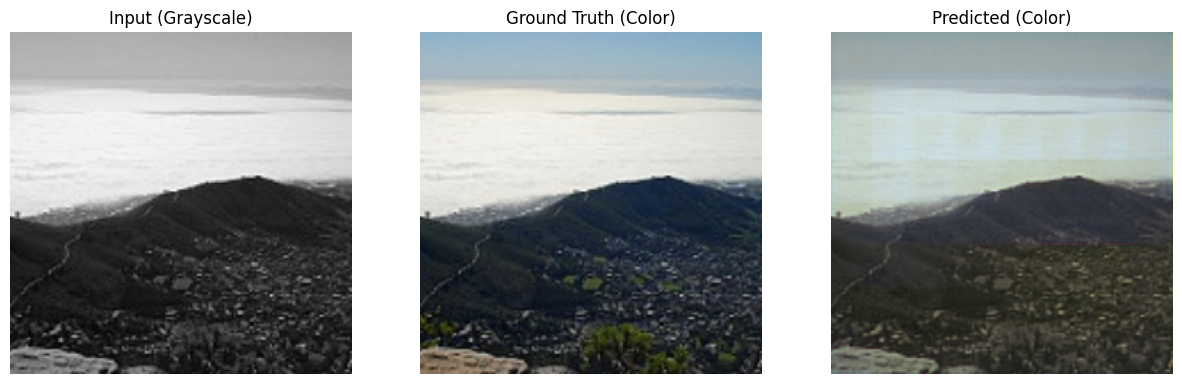

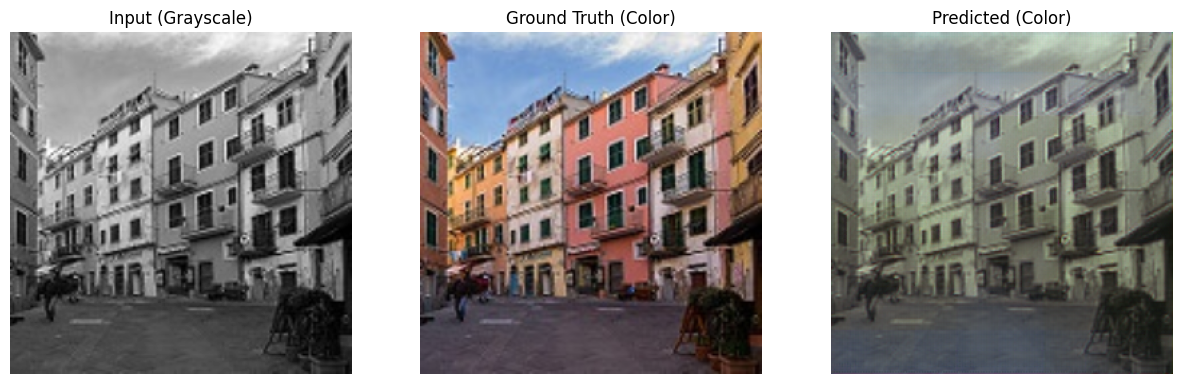

In [19]:
generate_examples(autoencoder_l1, test_generator, num_examples=5)